# Poultry Disease Classification using ResNet-18, DenseNet121, and VGG16 in PyTorch

<img src="https://www.venturagraininc.com/wp-content/uploads/2018/06/ThinkstockPhotos-478287121.jpg" width="800">

## Overview

This notebook implements a poultry disease classification system using **ResNet-18**, **DenseNet121**, and **VGG16** architectures in PyTorch. The goal is to accurately classify poultry diseases based on a curated dataset of fecal images. By comparing the performance of these three CNN models, we aim to determine which one performs best for this task.

### Dataset Description

The Poultry Pathology Visual Dataset contains a diverse collection of poultry fecal images categorized into four classes:
- Coccidiosis
- Healthy
- Newcastle Disease
- Salmonella

### Key Steps

1. **Data Loading and Preprocessing**: The dataset is loaded and preprocessed.
2. **Model Definition**: ResNet-18, DenseNet121, and VGG16 architectures are defined and configured for poultry disease classification.
3. **Model Training**: Each model is trained on the same training set.
4. **Model Evaluation**: Models' performance is assessed on the test set.
5. **Comparison of Results**: Graphs are used to compare the training process, accuracy, and loss for each model.

## Step 1: Data Loading and Preparation

We'll use the same data transformations and loaders across all three models to ensure a fair comparison.

In [1]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchvision.models import resnet18, densenet121, vgg16
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    # Model parallelism for multi-GPU setup
    def model_parallel(model):
        return torch.nn.DataParallel(model).to(device)
else:
    def model_parallel(model):
        return model.to(device)

Using 2 GPUs.


## Step 2: Data Loading and Preparation
We will load and preprocess the dataset using transformations. These transformations include resizing the images to 224x224 and normalizing them.

In [2]:
# Define transformations for the dataset
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets (train, validation, test)
batch_size = 64
train_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/poultry-diseases/data/data/train', transform=data_transforms)
val_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/poultry-diseases/data/data/val', transform=data_transforms)
test_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/poultry-diseases/data/data/test', transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

class_names = ["Coccidiosis", "Healthy", "Newcastle Disease", "Salmonella"]

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Step 3: Define Models

We'll initialize three models: ResNet-18, DenseNet121, and VGG16. We'll modify their output layers to match the number of classes (4 classes in this dataset).

In [3]:
# Define function to initialize models
def initialize_model(model_name, num_classes):
    if model_name == "resnet18":
        model = resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "densenet121":
        model = densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif model_name == "vgg16":
        model = vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    return model_parallel(model)  # Send model to GPU(s)

# Initialize the models
resnet_model = initialize_model("resnet18", num_classes=4)
densenet_model = initialize_model("densenet121", num_classes=4)
vgg_model = initialize_model("vgg16", num_classes=4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

## Step 4: Define Optimizer, Loss Function, and Scheduler
We will use the same optimizer, loss function, and learning rate scheduler for all models.

In [4]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer and learning rate scheduler
def get_optimizer(model):
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.2, min_lr=1e-5)
    return optimizer, scheduler

# Initialize optimizers and schedulers for each model
resnet_optimizer, resnet_scheduler = get_optimizer(resnet_model)
densenet_optimizer, densenet_scheduler = get_optimizer(densenet_model)
vgg_optimizer, vgg_scheduler = get_optimizer(vgg_model)

## Step 5: Training Loop with Progress Bar
We will now define the training loop, including progress bars for each epoch. This loop will train the models for 30 epochs and display the training progress for each batch.

In [5]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import os

def train_model(model, optimizer, scheduler, train_loader, val_loader, model_name, num_epochs=30, accumulation_steps=4):
    best_val_loss = float('inf')
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    scaler = GradScaler()  # For mixed precision training

    # Directory to save models
    save_dir = '/kaggle/working'
    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Initialize progress bar for training
        progress_bar = tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{num_epochs}", position=0, leave=True)

        # Zero the optimizer's gradients before accumulation starts
        optimizer.zero_grad()

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass with mixed precision
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels) / accumulation_steps  # Normalize loss by accumulation steps

            # Backward pass with gradient scaling
            scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0:
                # Apply gradients after accumulating for `accumulation_steps` batches
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()  # Reset gradients

            running_loss += loss.item() * accumulation_steps
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Update progress bar
            progress_bar.update(1)
            progress_bar.set_postfix({"Batch Loss": running_loss / (total_train / batch_size)})

        # Close the progress bar after the epoch
        progress_bar.close()

        train_accuracy = 100 * correct_train / total_train

        # Validation after each epoch
        val_loss, val_accuracy = evaluate_model(model, val_loader)

        # Save metrics for plotting
        history["train_loss"].append(running_loss / len(train_loader))
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_accuracy)
        history["val_acc"].append(val_accuracy)

        # Update scheduler
        scheduler.step(val_loss)

        # Clear GPU cache after each epoch to free memory
        torch.cuda.empty_cache()

        # Save model checkpoint
        model_save_path = os.path.join(save_dir, f"{model_name}_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved at {model_save_path}")

        # Print epoch results and completion percentage
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {running_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")

    return history

## Step 6: Evaluate Model Performance
The evaluate_model function performs validation by calculating the loss and accuracy on the validation set.

In [6]:
def evaluate_model(model, val_loader):
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculations for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    return val_loss / len(val_loader), val_accuracy

## Step 7: Train and Compare Models
We will now train all three models and compare their training performance using the plot_metrics function.

In [7]:
# Train the models and capture their training history

# Train ResNet model
history_resnet = train_model(resnet_model, resnet_optimizer, resnet_scheduler, train_loader, val_loader, "resnet18", num_epochs=3)

resnet_final_path = "/kaggle/working/resnet18_final.pth"
torch.save(resnet_model.state_dict(), resnet_final_path)
print(f"Final ResNet model saved at {resnet_final_path}")

/tmp/ipykernel_23/208636244.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training



Epoch 1/3


Training Epoch 1/3:   0%|          | 0/6250 [00:00<?, ?it/s]/tmp/ipykernel_23/208636244.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training Epoch 1/3: 100%|██████████| 6250/6250 [12:39<00:00,  8.23it/s, Batch Loss=0.284]


Model saved at /kaggle/working/resnet18_epoch_1.pth
Epoch 1/3 - Train Loss: 0.2840, Val Loss: 0.2009, Train Acc: 89.37%, Val Acc: 92.52%

Epoch 2/3


Training Epoch 2/3: 100%|██████████| 6250/6250 [11:14<00:00,  9.27it/s, Batch Loss=0.186]


Model saved at /kaggle/working/resnet18_epoch_2.pth
Epoch 2/3 - Train Loss: 0.1858, Val Loss: 0.1770, Train Acc: 93.05%, Val Acc: 93.35%

Epoch 3/3


Training Epoch 3/3: 100%|██████████| 6250/6250 [11:13<00:00,  9.28it/s, Batch Loss=0.149]


Model saved at /kaggle/working/resnet18_epoch_3.pth
Epoch 3/3 - Train Loss: 0.1494, Val Loss: 0.1522, Train Acc: 94.40%, Val Acc: 94.38%
Final ResNet model saved at /kaggle/working/resnet18_final.pth


In [8]:
# Train DenseNet model
history_densenet = train_model(densenet_model, densenet_optimizer, densenet_scheduler, train_loader, val_loader, "densenet121", num_epochs=3)
densenet_final_path = "/kaggle/working/densenet121_final.pth"
torch.save(densenet_model.state_dict(), densenet_final_path)
print(f"Final DenseNet model saved at {densenet_final_path}")

/tmp/ipykernel_23/208636244.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training



Epoch 1/3


Training Epoch 1/3:   0%|          | 0/6250 [00:00<?, ?it/s]/tmp/ipykernel_23/208636244.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training Epoch 1/3: 100%|██████████| 6250/6250 [39:14<00:00,  2.65it/s, Batch Loss=0.243]


Model saved at /kaggle/working/densenet121_epoch_1.pth
Epoch 1/3 - Train Loss: 0.2432, Val Loss: 0.1620, Train Acc: 90.97%, Val Acc: 93.94%

Epoch 2/3


Training Epoch 2/3: 100%|██████████| 6250/6250 [39:12<00:00,  2.66it/s, Batch Loss=0.161]


Model saved at /kaggle/working/densenet121_epoch_2.pth
Epoch 2/3 - Train Loss: 0.1605, Val Loss: 0.1447, Train Acc: 94.06%, Val Acc: 94.53%

Epoch 3/3


Training Epoch 3/3: 100%|██████████| 6250/6250 [39:18<00:00,  2.65it/s, Batch Loss=0.132]


Model saved at /kaggle/working/densenet121_epoch_3.pth
Epoch 3/3 - Train Loss: 0.1324, Val Loss: 0.1287, Train Acc: 95.10%, Val Acc: 95.21%
Final DenseNet model saved at /kaggle/working/densenet121_final.pth


In [9]:
# Train VGG model
history_vgg = train_model(vgg_model, vgg_optimizer, vgg_scheduler, train_loader, val_loader, "vgg16", num_epochs=3)
vgg_final_path = "/kaggle/working/vgg16_final.pth"
torch.save(vgg_model.state_dict(), vgg_final_path)
print(f"Final VGG model saved at {vgg_final_path}")

/tmp/ipykernel_23/208636244.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training



Epoch 1/3


Training Epoch 1/3:   0%|          | 0/6250 [00:00<?, ?it/s]/tmp/ipykernel_23/208636244.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training Epoch 1/3: 100%|██████████| 6250/6250 [35:46<00:00,  2.91it/s, Batch Loss=0.704]


Model saved at /kaggle/working/vgg16_epoch_1.pth
Epoch 1/3 - Train Loss: 0.7038, Val Loss: 0.4687, Train Acc: 71.44%, Val Acc: 81.09%

Epoch 2/3


Training Epoch 2/3: 100%|██████████| 6250/6250 [35:41<00:00,  2.92it/s, Batch Loss=0.4]


Model saved at /kaggle/working/vgg16_epoch_2.pth
Epoch 2/3 - Train Loss: 0.3997, Val Loss: 0.3680, Train Acc: 84.96%, Val Acc: 86.59%

Epoch 3/3


Training Epoch 3/3: 100%|██████████| 6250/6250 [35:39<00:00,  2.92it/s, Batch Loss=0.338]


Model saved at /kaggle/working/vgg16_epoch_3.pth
Epoch 3/3 - Train Loss: 0.3376, Val Loss: 0.3385, Train Acc: 87.47%, Val Acc: 87.46%
Final VGG model saved at /kaggle/working/vgg16_final.pth


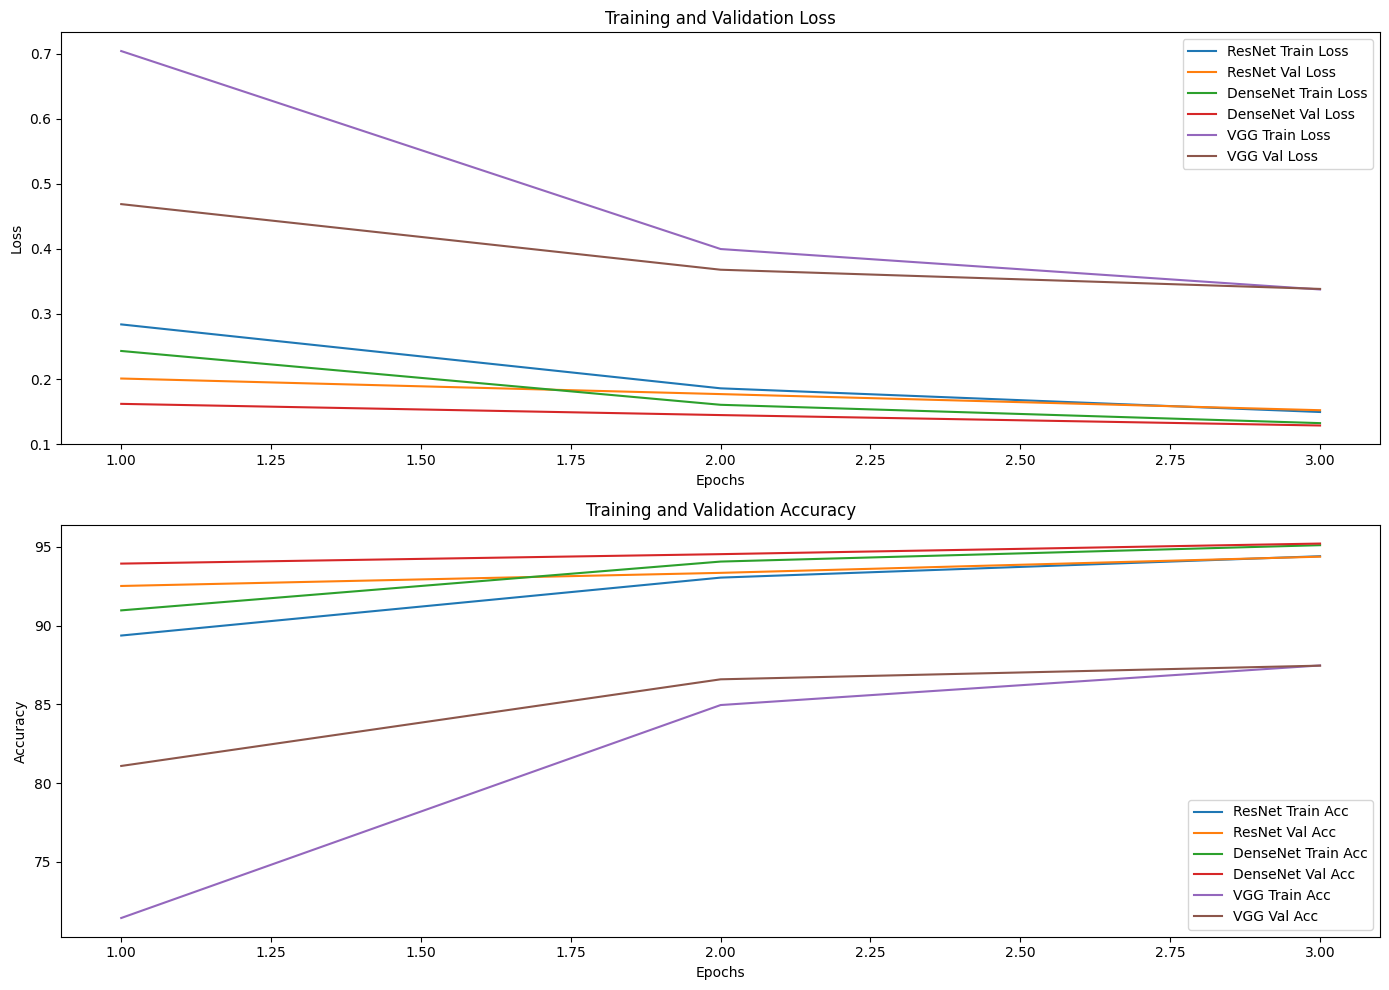

In [10]:
# Plot the metrics for comparison
def plot_metrics(history_resnet, history_densenet, history_vgg):
    epochs = range(1, len(history_resnet["train_loss"]) + 1)

    plt.figure(figsize=(14, 10))

    # Loss plot
    plt.subplot(2, 1, 1)
    plt.plot(epochs, history_resnet["train_loss"], label='ResNet Train Loss')
    plt.plot(epochs, history_resnet["val_loss"], label='ResNet Val Loss')
    plt.plot(epochs, history_densenet["train_loss"], label='DenseNet Train Loss')
    plt.plot(epochs, history_densenet["val_loss"], label='DenseNet Val Loss')
    plt.plot(epochs, history_vgg["train_loss"], label='VGG Train Loss')
    plt.plot(epochs, history_vgg["val_loss"], label='VGG Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(2, 1, 2)
    plt.plot(epochs, history_resnet["train_acc"], label='ResNet Train Acc')
    plt.plot(epochs, history_resnet["val_acc"], label='ResNet Val Acc')
    plt.plot(epochs, history_densenet["train_acc"], label='DenseNet Train Acc')
    plt.plot(epochs, history_densenet["val_acc"], label='DenseNet Val Acc')
    plt.plot(epochs, history_vgg["train_acc"], label='VGG Train Acc')
    plt.plot(epochs, history_vgg["val_acc"], label='VGG Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot results
plot_metrics(history_resnet, history_densenet, history_vgg)

## Step 8: Test the Models
Finally, we will evaluate each trained model on the test dataset.

In [11]:
def test_model(model):
    model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")
    return test_loss / len(test_loader), test_accuracy

# Evaluate the models on test set
test_resnet = test_model(resnet_model)
test_densenet = test_model(densenet_model)
test_vgg = test_model(vgg_model)

Test Loss: 0.1510, Test Accuracy: 94.38%
Test Loss: 0.1273, Test Accuracy: 95.29%
Test Loss: 0.3380, Test Accuracy: 87.48%


## Conclusion

This notebook demonstrates how to compare the performance of three popular CNN architectures (ResNet-18, DenseNet121, and VGG16) on poultry disease classification. After training, we use visualizations to compare the models and test them on unseen data to determine which model provides the highest accuracy.